In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from matplotlib import animation
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

In [2]:
cities = pd.read_csv('cities.csv')

In [3]:
POPULATION = 'Население'
CITY = 'Город'
REGION = 'Регион'
LATITUDE = 'Широта'
LONGITUDE = 'Долгота'

In [4]:
N = 30  # how many cities to use

In [5]:
cities[POPULATION] = pd.to_numeric(cities[POPULATION])
sorted_cities = cities.sort_values(by=[POPULATION], na_position='first', ascending=False)
top_cities = sorted_cities[:N]
top_cities.head()

,Индекс,Тип региона,Регион,Тип района,Район,Тип города,Город,Тип н/п,Н/п,Код КЛАДР,...,Уровень по ФИАС,Признак центра района или региона,Код ОКАТО,Код ОКТМО,Код ИФНС,Часовой пояс,Широта,Долгота,Федеральный округ,Население
506,101000.0,г,Москва,NaN,NaN,NaN,NaN,NaN,NaN,7700000000000,...,1: регион,0,45000000000,NaN,7700,UTC+3,55.753879,37.620373,Центральный,11514330
782,190000.0,г,Санкт-Петербург,NaN,NaN,NaN,NaN,NaN,NaN,7800000000000,...,1: регион,0,40000000000,NaN,7800,UTC+3,59.939125,30.315822,Северо-Западный,4848742
643,630000.0,обл,Новосибирская,NaN,NaN,г,Новосибирск,NaN,NaN,5400000100000,...,4: город,2,50401000000,5.070100e+10,5400,UTC+7,55.028102,82.921057,Сибирский,1498921
828,620000.0,обл,Свердловская,NaN,NaN,г,Екатеринбург,NaN,NaN,6600000100000,...,4: город,2,65401000000,6.570100e+07,6600,UTC+5,56.838633,60.605489,Уральский,1377738
615,603000.0,обл,Нижегородская,NaN,NaN,г,Нижний Новгород,NaN,NaN,5200000100000,...,4: город,2,22401000000,2.270100e+07,5200,UTC+3,56.324209,44.005395,Приволжский,1250615


In [6]:
names = top_cities[CITY].fillna(top_cities[REGION]).values
lats =  top_cities[LATITUDE].values
longs = top_cities[LONGITUDE].values

data = pd.DataFrame({'name': names, 'lat': lats, 'long': longs})
data.values

array([['Москва', 55.7538789, 37.6203735],
       ['Санкт-Петербург', 59.939125, 30.315822499999996],
       ['Новосибирск', 55.02810160000001, 82.92105749999999],
       ['Екатеринбург', 56.8386326, 60.6054887],
       ['Нижний Новгород', 56.3242093, 44.0053948],
       ['Казань', 55.794387699999994, 49.1115312],
       ['Самара', 53.195165700000004, 50.1067691],
       ['Омск', 54.9848136, 73.3674638],
       ['Челябинск', 55.160365899999995, 61.4007858],
       ['Ростов-на-Дону', 47.2224364, 39.7187866],
       ['Уфа', 54.734853, 55.9578647],
       ['Волгоград', 48.7072005, 44.5170207],
       ['Пермь', 58.0103211, 56.23417779999999],
       ['Красноярск', 56.009466, 92.85241620000001],
       ['Воронеж', 51.6592378, 39.1968284],
       ['Саратов', 51.530376000000004, 45.953025700000005],
       ['Краснодар', 45.040234999999996, 38.976080100000004],
       ['Тольятти', 53.520643799999995, 49.389461],
       ['Барнаул', 53.3481145, 83.7798362],
       ['Ижевск', 56.8527444, 53.21139

In [7]:
EARTH_R = 6371_000  # Earth radius in meters
EARTH_C = 2 * np.pi * EARTH_R  # Earth circumference in meters


def slc_dist(lat1, long1, lat2, long2):
    """Compute spherical distance between two points using Spherical Law of Cosines in meters
    Lat/Long should be degrees
    From: https://www.movable-type.co.uk/scripts/latlong.html"""
    lat1, long1, lat2, long2 = np.deg2rad([lat1, long1, lat2, long2])
    dl = long2 - long1
    return np.arccos( np.sin(lat1) * np.sin(lat2) + np.cos(lat1) * np.cos(lat2) * np.cos(dl) ) * EARTH_R

dist01 = slc_dist(data.lat[0], data.long[0], data.lat[1], data.long[1]) / 1000
str(np.round(dist01)) + ' km between ' + data.name[0] + ' and ' + data.name[1]

'634.0 km between Москва and Санкт-Петербург'

In [8]:
def cost(path):
    d = data.iloc[path]
    lat1 = d.lat
    long1 = d.long
    lat2 = np.roll(lat1, 1)
    long2 = np.roll(long1, 1)
    return sum(slc_dist(lat1, long1, lat2, long2))

def mutate(path):
    """ Reverse path before random index
    Idea from www.stat.yale.edu/~pollard/Courses/251.spring2013/Handouts/Chang-MoreMC.pdf"""
    mid = np.random.randint(0, len(path))
    return np.concatenate([path[mid::-1], path[mid + 1:]])

def sim_annealing(initial_t, changing_factor):
    """ Simulated Annealing shortest Tour search from cities from Data
    changing_factor should be < 1
    Returns (best tour, costs)"""
    p = np.arange(N)  # Current tour
    np.random.shuffle(p)
    
    c = cost(p)  # Current tour cost
    t = initial_t  # Current temperature
    rand = np.random.random_sample
    costs = [c]  # Costs for plots
    temps = [t]  # Temperatures
    tours = [p]  # Tours
    while t > 1:
        q = mutate(p)
        c2 = cost(q)
        
        ratio = np.exp(-(c2-c)/t)
        
        if c2 < c or (rand() <= ratio):  # New cost is less or Acceptance ratio is lucky enough
            p = q
            c = c2
        
        t *= changing_factor
        
        tours.append(p)
        costs.append(c)
        temps.append(t)
        
    return (tours, costs, temps)
    
    



In [9]:
def plot_sa(initial_t, changing_factor):
    p, costs, temps = sim_annealing(initial_t, changing_factor)
    plt.plot(np.array(costs) / 1_000_000)
    plt.title('Initial Temp: ' + str(initial_t) + ', changing_factor: ' + str(changing_factor))
    plt.xlabel('Time')
    plt.ylabel('Tour length in 1000 km')
    plt.show()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


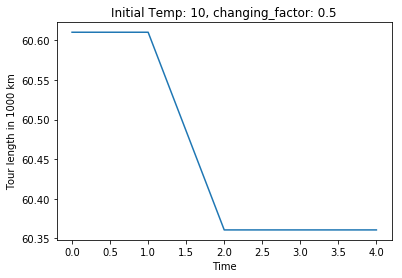

In [10]:
plot_sa(10, 0.5)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


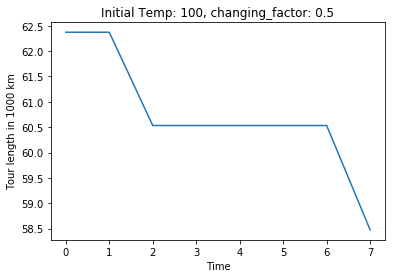

In [11]:
plot_sa(100, 0.5)

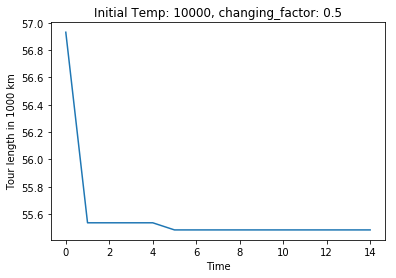

In [12]:
plot_sa(10000, 0.5)

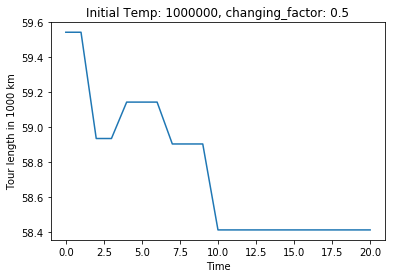

In [13]:
plot_sa(1000000, 0.5)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


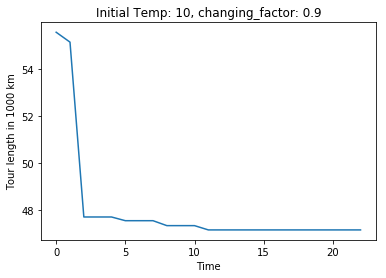

In [14]:
plot_sa(10, 0.9)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


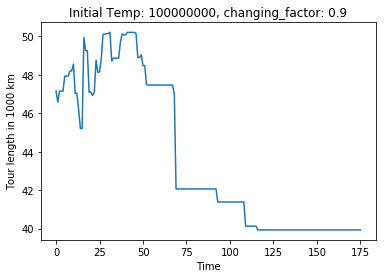

In [15]:
plot_sa(100000000, 0.9)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


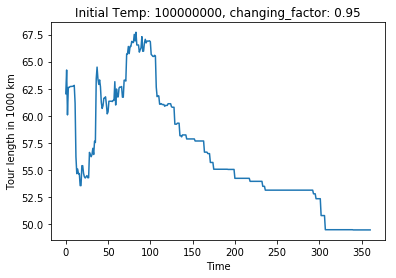

In [16]:
plot_sa(100000000, 0.95)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


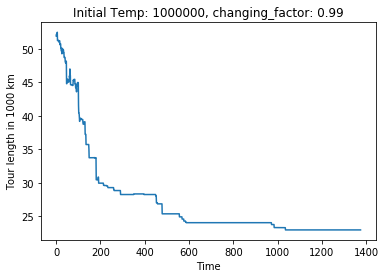

In [17]:
plot_sa(1000000, 0.99)

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


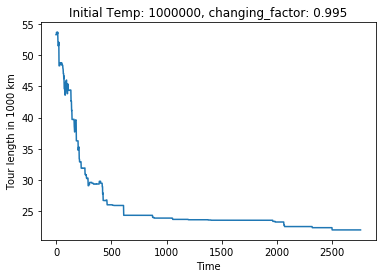

In [18]:
plot_sa(1000000, 0.995)

In [19]:
with open('russia(2).json', 'r') as f:
    russia = json.loads(f.read())
russia_coords = russia[0]['geojson']['coordinates']

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


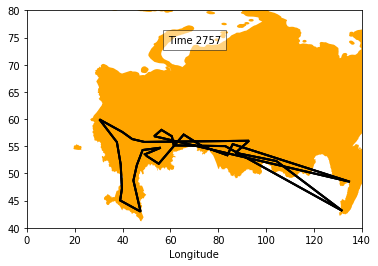

In [20]:
fig = plt.figure()

plt.xlabel('Latitude')
plt.xlabel('Longitude')


xlim1 = 0
xlim2 = 140
ylim1 = 40
ylim2 = 80

tour_orders, costs, temps = sim_annealing(1000000, 0.995)

for part in russia_coords:
    part = np.array(part[0])
    part[:, 0] = part[:, 0]
    ax = fig.add_subplot(111)
    
    codes = [Path.MOVETO] + ([Path.LINETO] * (len(part) - 2)) + [Path.CLOSEPOLY]
    
    path = Path(part, codes)
    patch = patches.PathPatch(path, facecolor='orange', linewidth=0)
    ax.add_patch(patch)
    ax.set_xlim(xlim1, xlim2)
    ax.set_ylim(ylim1, ylim2)

ax = fig.add_subplot(111)
ax.set_xlim(xlim1, xlim2)
ax.set_ylim(ylim1, ylim2)

tour_part = [[0, 0]]

patch = patches.Polygon(tour_part, fill=False, linewidth=2)
ax.add_patch(patch)

title = ax.text(0.5,0.85, "", bbox={'facecolor':'w', 'alpha':0.5, 'pad':5},
                transform=ax.transAxes, ha="center")

def init():
    patch.xy = [[0, 0]]
    ax.add_patch(patch)
    title.set_text('Time 0')
    return patch, title,

def animate(i):
    tour_order = tour_orders[i]
    tour_rows = data.iloc[tour_order]

    tour_part = np.stack([tour_rows.long, tour_rows.lat], axis=1)
    title.set_text('Time ' + str(i))

    patch.xy = tour_part
    return patch, title, 

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(tour_orders), interval=20, blit=True)

anim.save('animation.mp4', fps=30, 
          extra_args=['-vcodec', 'h264', 
                      '-pix_fmt', 'yuv420p'])
